In [1]:
#@title LIBRERIAS IMPORTADAS { run: "auto" }
## librerias para el funcionamiento del paquete

import numpy as np
import matplotlib.pyplot as plt
import math
#%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
import warnings
warnings.filterwarnings("ignore", message="""Caught 'unbalanced parenthesis at position 119' compiling regex""", category=UserWarning )
from scipy.optimize import fmin
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl
from scipy.special import factorial

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer
# Bin continuous data into intervals.
from sklearn.base import BaseEstimator, TransformerMixin
from numpy.lib.shape_base import apply_over_axes

from scipy.stats import norm
from sklearn.neighbors import KernelDensity

import os
import sys
import pandas as pd
# import pandas_datareader.data as web

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

from statsmodels.tsa import ar_model, arima_process, arima, arima_model
from statsmodels.tsa.ar_model import AutoReg
#!pip install numpy scipy patsy pandas
#!pip install statsmodels --upgrade

C:\Users\DeLL-PC\AppData\Local\Temp\ipykernel_1924\2998387767.py:37: UserWarning: DelftStack
  warnings.warn('DelftStack')


In [3]:
#@title CLASE REQUERIDA { run: "auto" }
"""

REQUIRED CLASSES

"""
class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

In [4]:
#@title RBF


"""
RBF
"""


class RBF:
   """
   CLASS IN CHARGE OF THE SIMULATION OF RADIAL BASE FUNCTION NETWORKS, WHICH CONSIST OF MIXED LEARNING NETWORKS, PRESENTS A 3-LAYER STRUCTURE,
   INPUT LAYER, HIDDEN LAYER (DETERMINES THE EUCLIDEAN DISTANCE BETWEEN THE WEIGHT VECTOR AND THE INPUT, PASSING THE RESULT THROUGH A GAUSSIAN RADIAL FUNCTION)
   , FINALLY THE THIRD LAYER OR OUTPUT LAYER IS APPLIED A LINEAR UNION OF THE SYSTEM.

   """
   def __init__(self, k=2, lr=0.01, epochs=100, inferStds=True):
        """
        Constructor
        ----------------------------------------------
        Parameters
        ---------------------------------------------
        ---------------------------------------------
        k : int=number of neurons in the hidden layer
        epochs: int= number of iterations to reduce the error
        inferStds : Boole= Defines the initial center for the analysis, initially inferred from the dataset  

        returns
        ----------------------------------------------------
        ----------------------------------------------------
        None

        """
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.inferStds = inferStds
        self.w = np.random.randn(k)
        self.b = np.random.randn(1)

   def rbf(self,x, c, s):
     return np.exp(-1 / (2 * s**2) * (x-c)**2)

   def kmeans(self,X, k):
          """Performs k-means clustering for 1D input
          
          Arguments:
              X {ndarray} -- A Mx1 array of inputs
              k {int} -- Number of clusters
          
          Returns:
              ndarray -- A kx1 array of final cluster centers
          """

          # randomly select initial clusters from input data
          clusters = np.random.choice(np.squeeze(X), size=k)
          prevClusters = clusters.copy()
          stds = np.zeros(k)
          converged = False

          while not converged:
              """
              compute distances for each cluster center to each point 
              where (distances[i, j] represents the distance between the ith point and jth cluster)
              """
              distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))

              # find the cluster that's closest to each point
              closestCluster = np.argmin(distances, axis=1)

              # update clusters by taking the mean of all of the points assigned to that cluster
              for i in range(k):
                  pointsForCluster = X[closestCluster == i]
                  if len(pointsForCluster) > 0:
                      clusters[i] = np.mean(pointsForCluster, axis=0)

              # converge if clusters haven't moved
              converged = np.linalg.norm(clusters - prevClusters) < 1e-6
              prevClusters = clusters.copy()

          distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
          closestCluster = np.argmin(distances, axis=1)

          clustersWithNoPoints = []
          for i in range(k):
              pointsForCluster = X[closestCluster == i]
              if len(pointsForCluster) < 2:
                  # keep track of clusters with no points or 1 point
                  clustersWithNoPoints.append(i)
                  continue
              else:
                  stds[i] = np.std(X[closestCluster == i])

          # if there are clusters with 0 or 1 points, take the mean std of the other clusters
          if len(clustersWithNoPoints) > 0:
              pointsToAverage = []
              for i in range(k):
                  if i not in clustersWithNoPoints:
                      pointsToAverage.append(X[closestCluster == i])
              pointsToAverage = np.concatenate(pointsToAverage).ravel()
              stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))

          return clusters, stds

 

   def fit(self, X, y):
        """
         fit: function in charge of training the system by educating the weights and parameters of the hidden layer
         --------------------------------
         Parameters
         --------------------------------------------
         --------------------------------------------
         X {ndarray} -- A Mx1 array of inputs to train
         Y{ndarray} ---- A Mx1 array of outputs to train 
         --------------------------------------------
         --------------------------------------------

         Returns
         -------------------------------------------
         -------------------------------------------
         None
         -------------------------------------------
         -------------------------------------------

        """
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = self.kmeans(X, self.k)
        else:
            # use a fixed std 
            self.centers, _ = self.kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)

        # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b

                loss = (y[i] - F).flatten() ** 2
                print('Loss: {0:.2f}'.format(loss[0]))

                # backward pass
                error = -(y[i] - F).flatten()

                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error

   def predict(self, X):
        """
         predict: function in charge of given a set of test data generate the output due to the previous training of the system
         --------------------------------------
         --------------------------------------
         Parameters
         --------------------------------------------
         --------------------------------------------
         X {ndarray} -- A Mx1 array of inputs to test

         Returns
         ----------------------------------------------
         ----------------------------------------------
         y {ndarray} -- A Mx1 array of outputs to test

        """
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)









[0.71108568 0.03470282 0.82218176 0.82161444 0.48224986 0.55752789
 0.87287044 0.39973725 0.24470601 0.24398877 0.09552321 0.78248072
 0.15971147 0.82311129 0.68539512 0.73147346 0.82060929 0.01418402
 0.91138273 0.90588962 0.20936694 0.23609021 0.15375695 0.8330731
 0.59632408 0.65411012 0.8380026  0.37461059 0.49831052 0.06472692
 0.73364506 0.17510412 0.82400982 0.10122338 0.27053597 0.55677757
 0.7006175  0.86048999 0.7973375  0.35608045 0.69343581 0.6123204
 0.65528448 0.53226516 0.11286643 0.82808126 0.28758588 0.8130736
 0.81729284 0.49483614 0.53863155 0.45429962 0.16995705 0.65405232
 0.06069778 0.97254952 0.16691181 0.41345849 0.53144734 0.59852474
 0.4698133  0.47710854 0.78965648 0.51129816 0.12642191 0.83285718
 0.94689016 0.87672537 0.39072726 0.33943164 0.35930218 0.35432982
 0.27584463 0.64308437 0.99067077 0.97069241 0.81997162 0.05096143
 0.22139652 0.60846169 0.58394597 0.69644388 0.53287573 0.69715834
 0.3074755  0.02309614 0.06220028 0.3584764  0.34375703 0.0041879

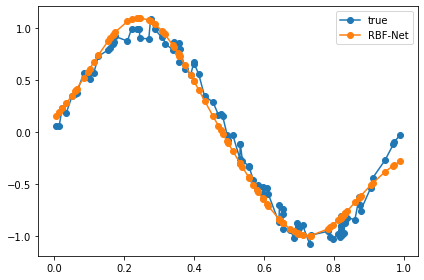

In [5]:
#@title EXAMPLE RBF

## EJEMPLO DE USO DE LA LIBRERIA

### PERMITE ENCAPSULAR EL EJEMPLO EN EL ARCHIVO Y NO MOSTRARLO A LA HORA DE REALIZAR LA IMPORTACIÓN DE LAS FUNCIONES, QUEDA COMO MODELO PRACTICO

if __name__ == "__main__":

        # sample inputs and add noise
        NUM_SAMPLES = 100
        X = np.random.uniform(0., 1., NUM_SAMPLES)
        print(X)
        X = np.sort(X, axis=0)
        print(X)
        noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
        y = np.sin(2 * np.pi * X)  + noise

        rbfnet = RBF(lr=1e-2, k=2, inferStds=True)
        rbfnet.fit(X, y)

        y_pred = rbfnet.predict(X)

        plt.plot(X, y, '-o', label='true')
        plt.plot(X, y_pred, '-o', label='RBF-Net')
        plt.legend()

        plt.tight_layout()
        plt.show()


In [6]:
#@title MVE



"""
MVE

"""

class MVE():
  """
  
        class that is in charge of handling the estimation by maximum likelihood, 
        for which 3 parameters are entered:
         --------------------------------------
         --------------------------------------
         Parameters
         --------------------------------------------
         X_function_Estimate {ndarray} -- Array that have the function 
         that needs to be estimated under some probability model.

         plot{Boolean}-- Parameter that indicate if the user want to plot the 
         log likely hood function. [default:True]

         hist{Boolean}-- Parameter that indicate if the user want to plot the 
         histogram with the estimate function. [default:True]


  """
  def __init__(self,X_function_estimate: np.array,plot=True,hist=True):
    self.X_function_estimate=X_function_estimate
    self.plot=plot
    self.hist=hist
    self.N=len(self.X_function_estimate)
  
  def Gaussian(self,median_limits: np.array, varian_limits: np.array,espace : float =0.10):
     """
      Function that make the MVE with a gaussian distribution
      ---------------------------------------------------------------
      Parameters
      ---------------------------------------------------------------
      median_limits{np.array}--array with 2 values that means the limits of the arrays of
      possible means.

      varian_limits{np.array}--array with 2 values that means the limits of the arrays of
      possible variances.
      espace{float}--constant  for the spacing of the vector of means and variances

      Returns
      ---------------------------------------------------------------
      media_estimate{float}-- THE ESTIMATED AVERAGE FOR THE FUNCTION 
      varian_estimate{float}-- THE ESTIMATED VARIANCE FOR THE FUNCTION
      gaussian_estimate{np.array}-- THE ESTIMATED DISTRIBUTION

      
     """  
     
     media = np.arange(median_limits[0], median_limits[1], espace)
     varian = np.arange(varian_limits[0], varian_limits[1], espace)
     media, varian = np.meshgrid(media, varian)
     log = -(self.N/2*np.log(2*np.pi)+self.N/2*np.log(varian)+(np.sum(np.square(self.X_function_estimate))-2*media*np.sum(self.X_function_estimate)\
                                                   +self.N*media**2)/(2*varian))
     posicionmax=np.where( log== np.amax(log))
     media_estimate=media[posicionmax[0],posicionmax[1]]
     varian_estimate=varian[posicionmax[0],posicionmax[1]]


     
     if(self.plot):
      fig=pl.figure(figsize=(6,6))
      ax=Axes3D(fig)
      ax.plot_surface(media,varian,log)
      pl.title("log likely hood of gaussian [mean(X) and varianza[Y]] ")
      pl.show()

     gaussian_estimate= np.random.normal(media_estimate, np.sqrt(varian_estimate), N)  
     if(self.hist):
       Nbins = int(1 + 3.322*np.log2(self.N))
       plt.figure(figsize=(8,8))
       plt.hist(self.X_function_estimate,bins=Nbins,color="orange",label="Original")
       plt.hist(gaussian_estimate,bins=Nbins,color="blue",label="Estimation-Varian {}-median {}".format(varian_estimate,media_estimate))
       plt.legend()
       plt.title("original and estimated comparison")

    
     return media_estimate,varian_estimate,gaussian_estimate

  def Exponential(self,lambda_limits:np.array,espace : float =0.10):
    """
      Function that make the MVE with a Exponential distribution
      ---------------------------------------------------------------
      Parameters
      ---------------------------------------------------------------
      lambda_limits{np.array}--array with 2 values that means the limits of the arrays of
      possible lambdas.

      espace{float}--constant  for the spacing of the vector of lambdas

      Returns
      ---------------------------------------------------------------
      lambda_estimate{float}-- THE ESTIMATED lambda FOR THE FUNCTION 
      estimated_exponential{np.array}-- THE ESTIMATED DISTRIBUTION

    """
    
    lambdas = np.arange(lambda_limits[0], lambda_limits[1], espace)
    log_estimation=self.N*np.log(lambdas)-lambdas*np.sum(self.X_function_estimate)
    posicionmax=np.where( log_estimation== np.amax(log_estimation))
    lambda_estimate=lambdas[posicionmax]
    estimated_exponential=np.random.exponential(1/lambda_estimate,size=self.N)
    if(self.plot):
      plt.figure(figsize=(6,6))
      plt.plot(lambdas, log_estimation)
      plt.xlabel('$\lambda$')
      plt.ylabel('log likely hood')
      plt.plot(lambda_estimate,log_estimation[posicionmax],color="green",label="Lambda Estimated: {}".format(lambda_estimate),marker='o')
      plt.legend()
      plt.show()
    if(self.hist):
      Nbins = int(1 + 3.322*np.log2(self.N))
      plt.figure(figsize=(8,8))
      plt.hist(self.X_function_estimate,bins=Nbins,color="orange",label="Original")
      plt.hist(estimated_exponential,bins=Nbins,color="blue",label="Estimation-lambda{}".format(lambda_estimate))
      plt.legend()
      plt.title("original and estimated comparison")
    
    return lambda_estimate,estimated_exponential

  def Gauss_estimate_fit(self):
      """
       
      function used by the scipy library to acquire the mean and variance parameters 
      for a Gaussian distribution appropriate to the shape of the training vector

      Parameters
      ---------------------------------------------
      None

      Return
      ---------------------------------------------
      mean{float}--The mean estimate
      var{float}-- the var estimate 

      """

      mean,var=scipy.stats.distributions.norm.fit(self.X_function_estimate)
      
      return mean,var

  def Poisson(self,lambdas_limits:np.array,espace : float =0.10):
    """
      Function that make the MVE with a Poisson distribution
      ---------------------------------------------------------------
      Parameters
      ---------------------------------------------------------------
      lambda_limits{np.array}--array with 2 values that means the limits of the arrays of
      possible lambdas.

      espace{float}--constant  for the spacing of the vector of lambdas

      Returns
      ---------------------------------------------------------------
      lambda_estimate{float}-- THE ESTIMATED lambda FOR THE FUNCTION 
      estimated_poisson{np.array}-- THE ESTIMATED DISTRIBUTION

    """
    lam = np.arange(lambdas_limits[0], lambdas_limits[1], espace)
    log_est=-self.N*lam+np.log(lam)*np.sum(self.X_function_estimate)-np.sum(np.log(factorial(self.X_function_estimate)))
    p_max=np.where( log_est== np.amax(log_est))
    lambda_est=lam[p_max]
    estimated_poisson=np.random.poisson(lambda_est,self.N)
    if(self.plot):
      plt.figure(figsize=(6,6))
      plt.plot(lam, log_est)
      plt.xlabel('$\lambda$')
      plt.ylabel('log likely hood')
      plt.plot(lambda_est,log_est[p_max],color="green",label="Lambda Estimated: {}".format(lambda_est),marker='o')
      plt.legend()
      plt.show()
    if(self.hist):
      Nbins = int(1 + 3.322*np.log2(self.N))
      plt.figure(figsize=(8,8))
      plt.hist(self.X_function_estimate,bins=Nbins,color="orange",label="Original")
      plt.hist(estimated_poisson,bins=Nbins,color="blue",label="Estimation-lambda{}".format(lambda_est))
      plt.legend()
      plt.title("original and estimated comparison")
    
    return lambda_est,estimated_poisson





C:\Users\DeLL-PC\AppData\Local\Temp\ipykernel_1924\1979221157.py:71: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)


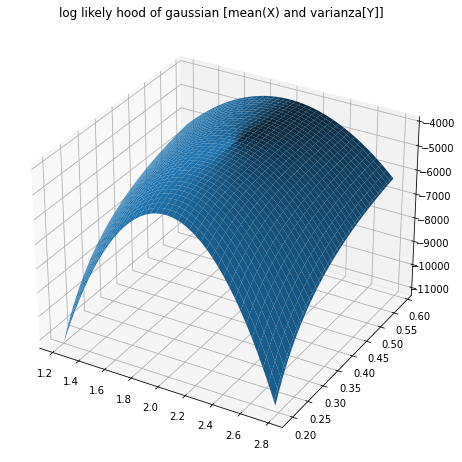

C:\Users\DeLL-PC\AppData\Local\Temp\ipykernel_1924\1979221157.py:107: RuntimeWarning: divide by zero encountered in log
  log_estimation=self.N*np.log(lambdas)-lambdas*np.sum(self.X_function_estimate)


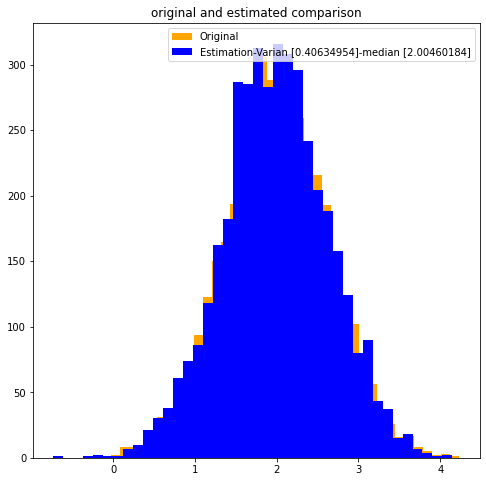

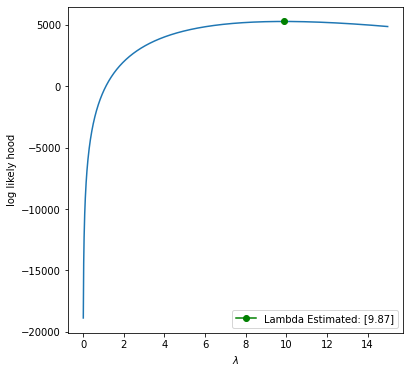

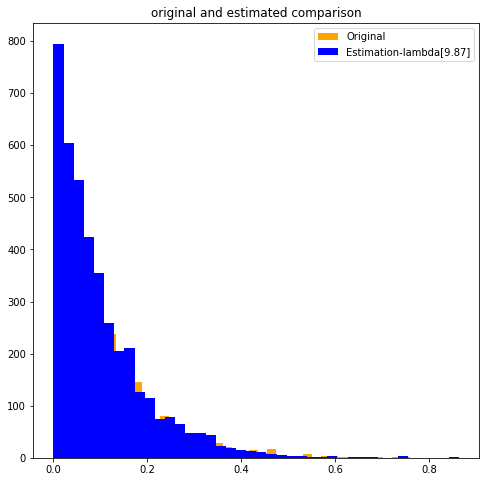

In [7]:
#@title EXAMPLE MVE(GAUSS-EXPONENTIAL)


if __name__=="__main__":

  """
  GAUSS
  """
  N =  4096 # // numero de muestras 

  #   parameter vector \theta=\mu, \sigma^2
  μ  = 2
  V2 = np.pi/8 
  x = np.random.normal(μ, np.sqrt(V2), N)    
  MVE1=MVE(x)
  Values_mean = np.array([μ-2*V2, μ+2*V2]) ##VECTOR DE MEDIAS 
  Values_var = np.array([V2/2, 1.5*V2]) # VECTOR DE VARIANZAS
  espace=0.01
  media_estimate,varian_estimat,gaussian_estimate=MVE1.Gaussian(Values_mean,Values_var,espace)
  

  """
  EXPONENTIAL
  """
  lam = 10
  exponencial=np.random.exponential(1/lam,size=N) ## EL PARAMETRO QUE SE INCRESA NO ES LAMBDA SINO 1/LAMBDA 
  MVE2=MVE(exponencial)
  lambdas_limits=np.array([0,15])
  espace=0.01
  lambda_estimate,estimated_exponential=MVE2.Exponential(lambdas_limits,espace)
  

C:\Users\DeLL-PC\AppData\Local\Temp\ipykernel_1924\1979221157.py:168: RuntimeWarning: divide by zero encountered in log
  log_est=-self.N*lam+np.log(lam)*np.sum(self.X_function_estimate)-np.sum(np.log(factorial(self.X_function_estimate)))


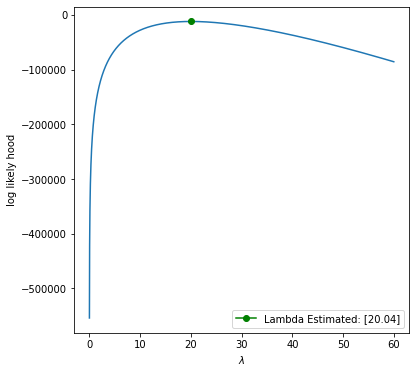

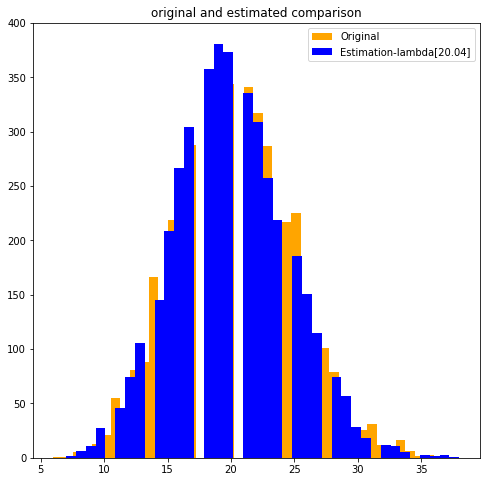

In [8]:
#@title EXAMPLE MVE (POISSON)
 
if __name__=="__main__":
      """
      POISSON

      """

      lam=20
      poisson=np.random.poisson(lam,size=N)
      MV3=MVE(poisson)
      lambdas_limits=np.array([0,60])
      espace=0.01
      lambda_estimate,estimated_poisson=MV3.Poisson(lambdas_limits,espace)

In [10]:
#@title KDE


class KDE():

   """ 
  class in charge of managing the estimation by the non-parametric kernel method

  PARAMETERS
  -------------------------------------------------------------------
  X_function{np.array}--array with the information of the function to which 
                        we need to find its respective distribution function
  H{float}-- bandwidth

  Returns
  -----------------------------------------------------------------------
  None

   """
   def __init__(self,X_function:np.array, H:float=0.5):
     self.X_function=X_function
     self.H=H

   def Gaussian(self):

      """
      FUNCTION THAT SELECT THE KERNEL FUNCTION LIKE GAUSSIAN

      PARAMETERS
      -------------------------
      None

      RETURNS
      ----------------------------------
      None

      """
      self.kernel="gaussian"
      self.__fit()
   def Tophat(self):
      """
      FUNCTION THAT SELECT THE KERNEL FUNCTION LIKE Tophat

      PARAMETERS
      -------------------------
      None

      RETURNS
      ----------------------------------
      None
      
      """
      self.kernel="tophat"
      self.__fit()
   def epanechnikov(self):
      """
      FUNCTION THAT SELECT THE KERNEL FUNCTION LIKE EPANECHNIKOV

      PARAMETERS
      -------------------------
      None

      RETURNS
      ----------------------------------
      None
      
      """
      self.kernel="epanechnikov"
      self.__fit()
   def exponential(self):
      """
      FUNCTION THAT SELECT THE KERNEL FUNCTION LIKE EXPONENTIAL

      PARAMETERS
      -------------------------
      None

      RETURNS
      ----------------------------------
      None
      
      """
      self.kernel="exponential"
      self.__fit()
   def linear(self):
      """
      FUNCTION THAT SELECT THE KERNEL FUNCTION LIKE LINEAR

      PARAMETERS
      -------------------------
      None

      RETURNS
      ----------------------------------
      None
      
      """
      self.kernel="linear"
      self.__fit()
   def cosine(self):
      """
      FUNCTION THAT SELECT THE KERNEL FUNCTION LIKE COSINE

      PARAMETERS
      -------------------------
      None

      RETURNS
      ----------------------------------
      None
      
      """
      self.kernel="cosine"
      self.__fit()
   def __fit(self):
      """
      FUNCTION THAT MAKE THE KERNEL ESTIMATION WITH A FIT ASOCIATE TO THE TYPE OF 
      THE KERNEL FUNCTION {SELF.KERNEL} AND THE DATA{SELF.X_FUNCTION}

      PARAMETERS
      -------------------------
      None

      RETURNS
      ----------------------------------
      None
      
      """
      self.kernelDensity=KernelDensity(kernel=self.kernel,bandwidth=self.H).fit(self.X_function.reshape(-1,1))
   def plot(self,X_plot:np.array,figure_size:tuple=(11,6)):
     """
      FUNCTION THAT COMPARE WITH A PLOT THE KERNEL ESTIMATION WITH THE HISTOGRAM
      OF THE SIGNAL.

      PARAMETERS
      -------------------------
      X_plot{np.array}--ARRAY WITH THE X-AXIS DID IT WITH NP.ARANGE(X_MIN,X_MAX,ESPACE)
      FIGURE_SIZE{TUPLE}: WITH THE SIZE OF THE GRAPHICS.

      RETURNS
      ----------------------------------
      None
      
     """

     try:
      X_plot=X_plot[:,np.newaxis]
      log_dens=self.kernelDensity.score_samples(X_plot)
      fig,ax=plt.subplots(figsize=figure_size)
      ax.plot(
          X_plot[:,0],np.exp(log_dens),color="navy",label="Kernel"
      )
      
      ax.hist(self.X_function,density = True)
      plt.show()
     except AttributeError:
       print("YOU NEED TO DECIDE A TYPE OF KERNEL BEFORE....")
      





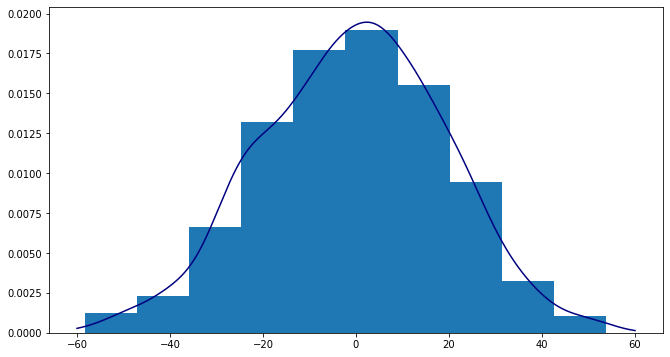

In [11]:
#@title EXAMPLE KDE

if __name__=="__main__":
    #  measures
    Señal_original = np.random.normal(0,20,500)
    #plt.hist(Señal_original,density=True)
    KERNEL=KDE(Señal_original,H=5)
    KERNEL.Gaussian()
    KERNEL.plot(np.linspace(-60,60,1000))


In [12]:
#@title GaussEstimation

"""

GAUSS

"""



class GaussianEstimation():
  """
  CLASS IN CHARGE OF HANDLING GAUSS ESTIMATION

  PARAMETERS
  --------------------------------------------

  N{int}-- Number of centers
  width_factor{float}--variance of gaussian model 
  RETURN
  ---------------------------------------------
  NONE
  """
  def __init__(self,N:int,width_factor:float=2.0):
    self.GaussFeatures=GaussianFeatures(N,width_factor)
    self.LinearRegression=LinearRegression()
    self.count=0
  def GenerateModel(self):
    """
  METHOD THAT GENERATE THE MODEL BASE FOR THE POSTERIOR TRAINING

  PARAMETERS
  --------------------------------------------
  NONE

  RETURN
  ---------------------------------------------
  NONE
    """
    if(self.count==0):
      self.gauss_model=make_pipeline(self.GaussFeatures,self.LinearRegression)
      self.count=1
    else:
      print("======================================")
      print("        MODEL ALREADY GENERATED       ")
      print("======================================")

  
  def Model_Fit(self,X_train:np.array,Y_train:np.array):
    """

    METHOD THAT MAKE THE TRAINING WITH A SET OF DATA TO TRAIN

    PARAMETERS
    --------------------------------------------------------
    X_train{np.array}: INPUT DATA
    Y_train{np.array}: EXIT EXPECTED DATA

    RETURNS
    -------------------------------------------------------
    None
    
    """
    
    try:
      print("Training Model..............")
      self.gauss_model.fit(X_train,Y_train)
      print("Model trained...............")
      
      
    except AttributeError:
      print("======================================")
      print("        GENERATE THE MODEL FIRST      ")
      print("======================================")
    except Exception as e:
      print("======================================")
      print("An exception occurred")
      print(e)
      print("======================================")
  def Model_predict(self,X_test:np.array):
    """

    METHOD THAT MAKE THE PREDICTION WITH A SET OF DATA TO TEST.

    PARAMETERS
    --------------------------------------------------------
    X_train{np.array}: INPUT DATA
    RETURNS
    -------------------------------------------------------
    Y_predict{np.array}: PREDICTED DATA
    
    """
    try:
     print("Starting Prediction........")
     Y_predict=self.gauss_model.predict(X_test)
     print("Prediction Complete........")
     return Y_predict
    except AttributeError:
      print("=============================================")
      print(" GENERATE THE MODEL FIRST OR TRAIN THE MODEL ")
      print("=============================================")
    except Exception as e:
      print("======================================")
      print("An exception occurred")
      print(e)
      print("======================================")




Training Model..............
Model trained...............
Starting Prediction........
Prediction Complete........


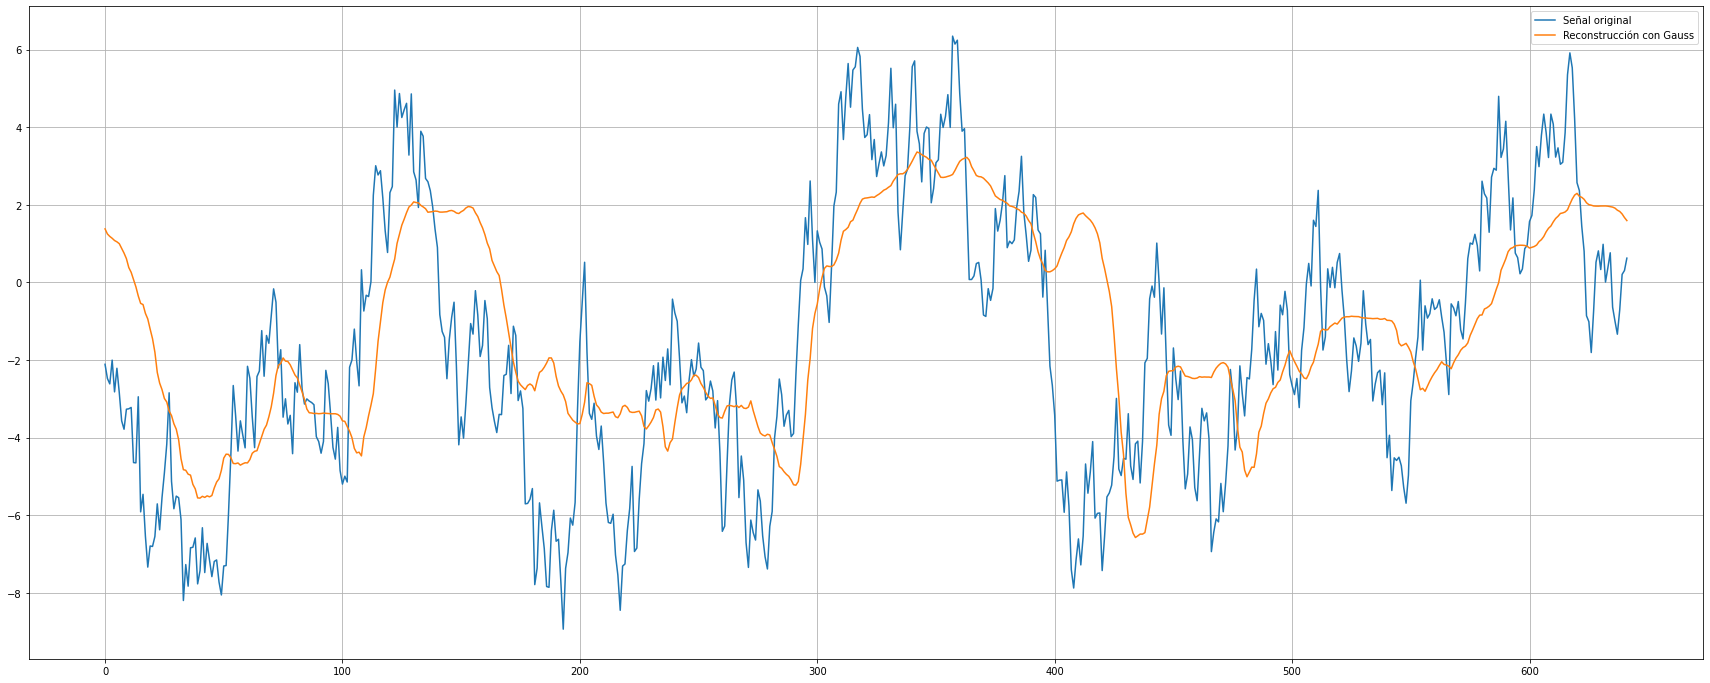

In [13]:
#@title EXAMPLE GAUSS_ESTIMATION
"""
EJEMPLO_GAUSS_ESTIMATION

"""

if __name__=="__main__":

  #GENERATE THE INITIAL DATA:


  # split into train and test sets
  # Simulate an AR(2) process
  alphas = np.array([.93, .0333])
  betas = np.array([0.])
  # Python requires us to specify the zero-lag value which is 1
  # Also note that the alphas for the AR model must be negated
  # We also set the betas for the MA equal to 0 for an AR(p) model
  # For more information see the examples at statsmodels.org
  n_samples = 2048
  ar = np.r_[1, -alphas]
  ma = np.r_[1, betas]
  ar2 = arima_process.arma_generate_sample(ar=ar, ma=ma, nsample=n_samples)
  dataset = ar2
  n_steps = 33
  step_back = n_steps

  train_size = int(len(dataset) * 0.67) 
  train_dataset, test_dataset = dataset[0:train_size], dataset[train_size:len(dataset)]

  X_train, Y_train = [], []
  for i in range(len(train_dataset)-step_back - 1):
      a = train_dataset[i:(i+step_back)]
      X_train.append(a)
      Y_train.append(train_dataset[i + step_back])
  X_train = np.array(X_train); Y_train = np.array(Y_train);

  X_test, Y_test = [], []
  for i in range(len(test_dataset)-step_back - 1):
      a = test_dataset[i:(i+step_back)]
      X_test.append(a)
      Y_test.append(test_dataset[i + step_back])
  X_test = np.array(X_test); Y_test = np.array(Y_test);



  ##GAUSS ESTIMATION

  Gauss_Estimate=GaussianEstimation(7,3)
  Gauss_Estimate.GenerateModel()
  Gauss_Estimate.Model_Fit(X_train,Y_train)
  Y_predict=Gauss_Estimate.Model_predict(X_test)


  # PLOTTING
  plt.figure(figsize=(30,12))
  plt.plot(Y_test, label = 'Señal original')
  #plt.plot(y_hat, label = 'Reconstrucción aprendida')
  plt.plot(Y_predict, label = 'Reconstrucción con Gauss')
  plt.legend()
  plt.grid()



    

   
   
   
   


In [ ]:
"""
FUNCIÓN PARA GENERAR LOS CONJUNTOS DE TESTEO Y ENTRENO DE UNA RED NEURONAL DE MANERA BASICA
"""
def Train_Test(Data:np.array,Nsamples:int,PorcentDivision:float=0.67):

    """
     function that generates me from a data set, 2 elements for testing and training.
     --------------------------------------------------------------------------------

     Parameters
     -------------------------------------------------------------------------------

     Data{np.array}: Array that has the information that needs to be split
     Nsamples{int}: value representing the size of the data set used to predict the next
     PorcentDivision{float}: represents the percentage of data that you want to be used for training and the rest for testing.

     Returns
     -------------------------------------------------------------------------------
     X_train{np.array}: Input vector for training
     Y_train{np.array}: Output vector for training
     X_test{np.array}:Input vector for testing
     Y_test{np.array}: Output vector for testing

    """
    train_size = int(len(dataset) * PorcentDivision) ## VALOR PARA DETERMINAR CUAL SERA EL PORCENTAJE DE DATOS UTILIZADOS PARA ENTRENO Y CUANTOS PARA TESTEO
    train_dataset, test_dataset = dataset[0:train_size], dataset[train_size:len(dataset)] ## COJE LAS MUESTRAS Y LAS PARTE EN 2 UNA PARA ENTRENO Y OTRAS 
    ## PARA TESTEO DEPENDIENDO DEL VALOR DEL PORCENTDIVISION ASIGNADO.


    ## ESTOY UTILIZANDO LA RED COMO PREDICTOR 
    X_train, Y_train = [], [] ## DEFINIMOS LOS VECTORES, PARA UBICAR LOS DATOS DE ENTRENO Y TESTEO
    ##TOMANDO LOS VALORES DE ENTRENO UBICADOS EN TRAIN_DATASET 
    ## RECORDAR LOS PRIMEROS STEP_BACK DATOS NO SON UTILIZADOS DESPUES PARA GENERAR LA RECONSTRUCCIÓN YA QUE TENEMOS QUE PARTIR DE UNA CANTIDAD DE VALORES PARA
    ## PREDECIR
    for i in range(len(train_dataset)-Nsamples - 1):
        a = train_dataset[i:(i+Nsamples)] ## AGREGO EN A CONJUNTO DE N_STEPS CANTIDAD DE DATOS 
        X_train.append(a)
        Y_train.append(train_dataset[i + Nsamples]) ## Y PREDIGO EL QUE SIGUE CON ESOS DATOS. 
    X_train = np.array(X_train); Y_train = np.array(Y_train); ## COMO ESTABA TRABAJANDO CON LISTAS VUELVO EL X_TRAIN EN UNA MATRIZ YA QUE SON VARIOS
    ### CONJUNTOS UTILIZADOS PARA PREDECIR EL VALOR SIGUIENTE

    X_test, Y_test = [], []
    for i in range(len(test_dataset)-Nsamples - 1):
        a = test_dataset[i:(i+Nsamples)]
        X_test.append(a)
        Y_test.append(test_dataset[i + Nsamples])
    X_test = np.array(X_test); Y_test = np.array(Y_test);
    ## DEVOLVEMOS LOS CONJUNTOS OBTENIDOS PARA TESTEO Y MUESTREO
    return X_train,Y_train,X_test,Y_test 


In [ ]:

"""

  FUNCIONES CUANTIZAR_BINARIZAR

"""

def Cuanti_PCM(Funcion_muestreada:np.array,bits:int=3,plot:bool=False):
        """
        Funcion encargada de realizar el proceso de cuantización, es decir limitar los valores discretizados
        asociados a una cantidad de bits.
        -----------------------------------------------------------------------------------------------------
        Parameters
        ----------------------------------------------------------------------------------------------------
        Funcion_muestreada{np.array}: ARREGLO CON LA SEÑAL DISCRETIZADA
        bits{int}: Entero que representa la cantidad de bits para la cuantización

        Returns
        --------------------------------------------------------------------------
        output_digital{np.array}: señal digital asociada a la cantidad de bits
        estados{np.array}: arreglo con todos los niveles usados para la cuantización
        """
        N_bits=bits ## DEFINIMOS NUMERO DE BITS
        Total_niveles=2**(N_bits) ## NIVELES ASOCIADOS A LA CANTIDAD DE BITS
        resolucion=((np.amax(Funcion_muestreada)-np.amin(Funcion_muestreada))/Total_niveles)  ##DEFINIMOS LA RESOLUCIÓN DEL DIGITALIZADOR
        estados=[] ## DEFINIMOS UN ARREGLO CON POSIBLES ESTADOS
        for i in range(0,Total_niveles):
            estados.append(np.amin(Funcion_muestreada)+resolucion*i)  
        
        output_digital=[] ## DEFINIMOS UN ARREGLO PARA NUESTRA SEÑAL DIGITAL 
        Estados_invertidos=list(reversed(estados)) ## REORGANIZAMOS EL ARREGLO DE ESTADOS
        for valor in Funcion_muestreada:
         if(valor>=estados[Total_niveles-1]):
            output_digital.append(estados[Total_niveles-1])
         else:
          for Estado_Posible in range(1,Total_niveles):
            if(valor>=Estados_invertidos[Estado_Posible]):
             output_digital.append(Estados_invertidos[Estado_Posible])
             break
        return output_digital,estados
def Matrix_bits(n:int):
          """
           Funcion que devuelve una matriz con estados binarios asociado a una cantidad de bits
           ------------------------------------------------------------------------------------
           Parameters
           ------------------------------------------------------------------------------------
           n{int}: entero asociado al numero de bits del cuantizador.

           Returns
           ------------------------------------------------------------------------------------
           Matriz de estados binarios
          """
          ## CODIFICACIÓN (BINARIZACIÓN)
          ## FUNCION PARA GENERAR LAS COMBINACIONES BINARIAS ASOCIADAS AL NUMERO DE BITS DEL SISTEMA 
          if n==0:
              return [[]]
          else:
            m = Matrix_bits(n-1)
            return [[i]+item for i in (0,1) for item in m]

def CheckState(States:np.array,Value:float):
  
  """
   funcion que analiza el estado en el cual se encuentra la señal cuantizada
   -------------------------------------------------------------------------
   Parameter
   ------------------------------------------------------------------------
   States{np.array}: arreglo con todos los estados posibles
   Value{float}: flotante que hace referencia al estado buscado

   Return
   ----------------------------------------------------------------------
   State{int-None}: Valor que indica la posición del estado buscado para el value asociado
                    en caso de no encontrarlo retorna None
   
  """
  State=None
  for i in range(0,len(States)):
    if(Value==States[i]):
      State=i
      break
  return State

